<a href="https://colab.research.google.com/github/Manditar2/NLI-con-red-neuronal-LSTM/blob/main/Proyecto_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences
from keras.callbacks import TensorBoard, EarlyStopping
from keras.layers import Input, Embedding, LSTM , Dense, Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D
from keras.metrics import TruePositives, FalsePositives,categorical_accuracy, TrueNegatives, FalseNegatives, Precision, Recall, AUC



In [14]:
nltk.download('stopwords')
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


--2023-05-28 21:14:56--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-28 21:14:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.06MB/s    in 2m 40s  

2023-05-28 21:17:38 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [15]:
#@title Cargar datos
df = pd.read_csv('/content/sample_data/snli_1.0_train.csv')
columnas = ['sentence1','sentence2','gold_label']
df = df[columnas]
df.dropna(axis=0, inplace=True) #Se eliminan datos nulos
df.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [16]:
df = df.loc[df['gold_label'] != "-"]   #Se botan las filas que contengan - y neutral
df = df.loc[df['gold_label'] != "neutral"]
df.shape

(28534, 3)

In [17]:
df = df.sample(frac = 1)
df["gold_label"] = (df["gold_label"] == "contradiction").astype(int)
df.head()

,sentence1,sentence2,gold_label
33672,"A group of people walk in the park, while some...","A bunch of people are in the park, some of the...",0
2063,3 safety jacket clad Construction workers appe...,3 construction workers on their lunch break.,1
24958,An older gentleman taking a walk.,A old man is taking a walk.,0
17154,One child carries another child on her back.,Children are playing together.,0
3294,A male is looking at different colored yarn we...,The man is wearing a white shirt,0


In [18]:
y = df['gold_label']
len(df)
X = df[['sentence1','sentence2']]

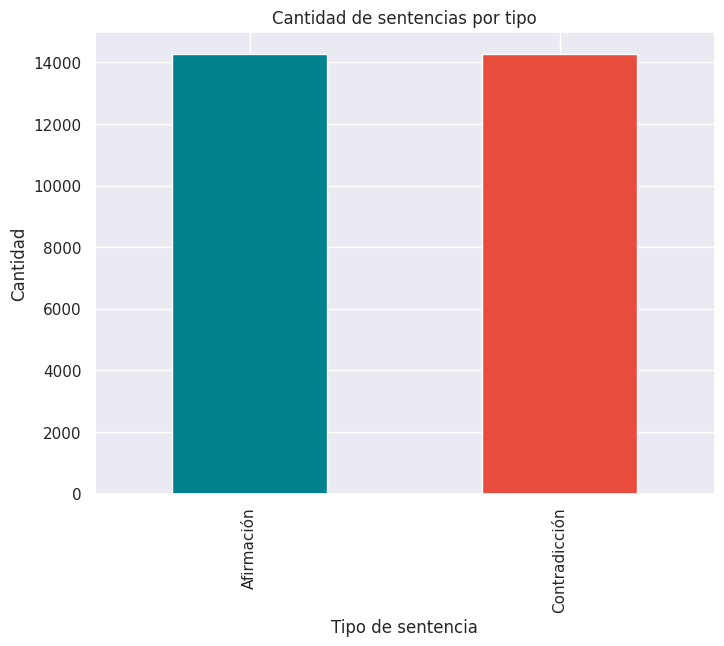

In [19]:
sns.set(style='darkgrid')
colores = ['#00818E', '#e74c3c']
counts = df['gold_label'].value_counts().rename({0: 'Afirmación', 1: 'Contradicción'})

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color = colores)
plt.title('Cantidad de sentencias por tipo')
plt.xlabel('Tipo de sentencia')
plt.ylabel('Cantidad')
plt.show()

In [20]:
#@title Limpieza de datos

def limpiarTexto(texto):
  texto = str(texto).lower()
  texto = re.sub('\[.*?\]', '', texto)
  texto = re.sub('<.*?>+', '', texto)
  texto = re.sub('\n', '', texto)
  texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)
  texto = re.sub('\w*\d\w*', '', texto)
  return texto

df.head()

,sentence1,sentence2,gold_label
33672,"A group of people walk in the park, while some...","A bunch of people are in the park, some of the...",0
2063,3 safety jacket clad Construction workers appe...,3 construction workers on their lunch break.,1
24958,An older gentleman taking a walk.,A old man is taking a walk.,0
17154,One child carries another child on her back.,Children are playing together.,0
3294,A male is looking at different colored yarn we...,The man is wearing a white shirt,0


In [21]:
df['sentence1'] = df['sentence1'].apply(limpiarTexto)
df['sentence2'] = df['sentence2'].apply(limpiarTexto)
df.head()

,sentence1,sentence2,gold_label
33672,a group of people walk in the park while some ...,a bunch of people are in the park some of them...,0
2063,safety jacket clad construction workers appea...,construction workers on their lunch break,1
24958,an older gentleman taking a walk,a old man is taking a walk,0
17154,one child carries another child on her back,children are playing together,0
3294,a male is looking at different colored yarn we...,the man is wearing a white shirt,0


In [22]:
#@title Pre procesamiento
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
  
df['sentence1'] = df['sentence1'].apply(remove_stopwords)
df['sentence2'] = df['sentence2'].apply(remove_stopwords)
df['sentence1'].shape
df['sentence2'].shape


(28534,)

In [23]:
stemmer = nltk.SnowballStemmer('english')
def stematizar(texto):
  texto = ' '.join(stemmer.stem(word) for word in texto.split(' ')) #Divide el texto, y aplica la función de stematización a cada palabra
  return texto
df['sentence1'] = df['sentence1'].apply(stematizar)
df['sentence2'] = df['sentence2'].apply(stematizar)
df.head()


,sentence1,sentence2,gold_label
33672,group peopl walk park talk phone,bunch peopl park phone,0
2063,safeti jacket clad construct worker appear po...,construct worker lunch break,1
24958,older gentleman take walk,old man take walk,0
17154,one child carri anoth child back,children play togeth,0
3294,male look differ color yarn wear white shirt,man wear white shirt,0


In [24]:
df['sentence1'].shape
df['sentence2'].shape

(28534,)

In [25]:
#@title Tokenización
sentencias_arreglo = np.asarray([df['sentence1'],df['sentence2']])
print(sentencias_arreglo)
sentencias_arreglo = sentencias_arreglo.reshape(-1,1)

[['group peopl walk park talk phone'
  ' safeti jacket clad construct worker appear poke someth interest shovel'
  'older gentleman take walk' ...
  'larg group look like martial artist practic' 'three biker stop town'
  'man sleeveless blue shirt athlet pant punch punch bag']
 ['bunch peopl park phone' ' construct worker lunch break'
  'old man take walk' ... 'small group footbal practic' 'angri dog'
  'man sleeveless red shirt bluejean nap couch']]


In [26]:
sentencias_arreglo.shape

(57068, 1)

In [27]:
print(sentencias_arreglo)

[['group peopl walk park talk phone']
 [' safeti jacket clad construct worker appear poke someth interest shovel']
 ['older gentleman take walk']
 ...
 ['small group footbal practic']
 ['angri dog']
 ['man sleeveless red shirt bluejean nap couch']]


In [28]:
sentencias_arreglo = sentencias_arreglo.reshape(sentencias_arreglo.shape[0])
sentencias_arreglo.shape

(57068,)

In [29]:
print(sentencias_arreglo)

['group peopl walk park talk phone'
 ' safeti jacket clad construct worker appear poke someth interest shovel'
 'older gentleman take walk' ... 'small group footbal practic' 'angri dog'
 'man sleeveless red shirt bluejean nap couch']


In [30]:
tokenizar = Tokenizer(num_words = 6000)
tokenizar.fit_on_texts(sentencias_arreglo) #Transforma a "número" las palabras dentro del arreglo


In [31]:
texto_original_seq = tokenizar.texts_to_sequences(df['sentence1']) #Guarda un arreglo que en vez de palabras, posee índices de palabras
texto_original = pad_sequences(texto_original_seq) #Agrega padding para estandarizar el tamaño
hipotesis_seq = tokenizar.texts_to_sequences(df['sentence2'])
hipotesis = pad_sequences(hipotesis_seq, maxlen = texto_original.shape[1])
print(hipotesis)

[[   0    0    0 ...    3   57  228]
 [   0    0    0 ...  103  437  478]
 [   0    0    0 ...    1   61   16]
 ...
 [   0    0    0 ...   22  134  382]
 [   0    0    0 ...    0 1174   10]
 [   0    0    0 ... 5120  447  207]]


In [32]:
encoder = LabelEncoder()
etiquetas = df['gold_label']
etiquetas = encoder.fit_transform(etiquetas)
etiquetas

array([0, 1, 0, ..., 1, 1, 1])

In [33]:
etiquetas = to_categorical(etiquetas)
etiquetas

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [34]:
texto_original.shape

(28534, 45)

In [35]:
hipotesis.shape

(28534, 45)

In [36]:
data_tokenizada = np.asarray([texto_original,hipotesis])
data_tokenizada

array([[[   0,    0,    0, ...,   57,   64,  228],
        [   0,    0,    0, ...,   85,  892,  345],
        [   0,    0,    0, ...,  483,   61,   16],
        ...,
        [   0,    0,    0, ...,  434,  528,  382],
        [   0,    0,    0, ...,  278,  327,  649],
        [   0,    0,    0, ..., 1141, 1141,  159]],

       [[   0,    0,    0, ...,    3,   57,  228],
        [   0,    0,    0, ...,  103,  437,  478],
        [   0,    0,    0, ...,    1,   61,   16],
        ...,
        [   0,    0,    0, ...,   22,  134,  382],
        [   0,    0,    0, ...,    0, 1174,   10],
        [   0,    0,    0, ..., 5120,  447,  207]]], dtype=int32)

In [37]:
data_tokenizada.shape

(2, 28534, 45)

In [38]:
data_tokenizada = data_tokenizada.reshape(data_tokenizada.shape[1], 2, data_tokenizada.shape[2])

In [39]:
data_tokenizada.shape

(28534, 2, 45)

In [40]:
tokenizar.word_index

{'man': 1,
 'woman': 2,
 'peopl': 3,
 'two': 4,
 'play': 5,
 'wear': 6,
 'sit': 7,
 'stand': 8,
 'girl': 9,
 'dog': 10,
 'boy': 11,
 'men': 12,
 'shirt': 13,
 'young': 14,
 'white': 15,
 'walk': 16,
 'blue': 17,
 'black': 18,
 'hold': 19,
 'look': 20,
 'red': 21,
 'group': 22,
 'outsid': 23,
 'person': 24,
 'street': 25,
 'three': 26,
 'front': 27,
 'ride': 28,
 'women': 29,
 'one': 30,
 'run': 31,
 'child': 32,
 'water': 33,
 'dress': 34,
 'children': 35,
 'watch': 36,
 'green': 37,
 'hat': 38,
 'work': 39,
 'jump': 40,
 'yellow': 41,
 'littl': 42,
 'bike': 43,
 'build': 44,
 'next': 45,
 'near': 46,
 'larg': 47,
 'ball': 48,
 'anoth': 49,
 'brown': 50,
 'jacket': 51,
 'around': 52,
 'pictur': 53,
 'hand': 54,
 'player': 55,
 'beach': 56,
 'park': 57,
 'crowd': 58,
 'small': 59,
 'sleep': 60,
 'take': 61,
 'field': 62,
 'eat': 63,
 'talk': 64,
 'guy': 65,
 'ladi': 66,
 'car': 67,
 'perform': 68,
 'camera': 69,
 'kid': 70,
 'outdoor': 71,
 'tabl': 72,
 'orang': 73,
 'grass': 74,
 'top'

In [41]:
#@title Embedding
vocabulario = len(tokenizar.word_index)

def gloveWork(archivo,vocabulario):
  #Se crea un diccionario palabra-vector de un modelo preentrenado(Glove)
  embeddings_index = {}
  file_ = open(archivo)
  for line in file_:
      arr = line.split()
      palabra = arr[0]
      vector = np.asarray(arr[1:],dtype='float32')
      embeddings_index[palabra] = vector
  file_.close() 

  tam_maximo = vocabulario +1
  indices_palabras = tokenizar.word_index
  embedding_matriz = np.zeros((tam_maximo,300)).astype(object)

  for palabrax, indice in indices_palabras.items():
    vector_entrenado = embeddings_index.get(palabrax)
    if vector_entrenado is not None:
      embedding_matriz[indice] = vector_entrenado

  return embedding_matriz


In [42]:
#@title Modelo
x = Input(shape=(data_tokenizada.shape[1], data_tokenizada.shape[2],))
p = TimeDistributed(Embedding(vocabulario + 1 , 300))(x)
p = TimeDistributed(LSTM(128, return_sequences=True))(p)
p = TimeDistributed(LSTM(64, return_sequences=True))(p)
x1 = TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(p)
x2 = TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(p)
concat = tf.keras.layers.concatenate([x1, x2])
p = tf.keras.layers.Dropout(0.35)(concat)
p = Flatten()(p)
p = Dense(2, activation="softmax")(p)

In [43]:
m = tf.keras.models.Model(inputs = x, outputs = p)

In [44]:
m.layers[1].set_weights([gloveWork("glove.6B.300d.txt", vocabulario)])

In [45]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 45)]      0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 2, 45, 300)  1995600     ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 2, 45, 128)  219648      ['time_distributed[0][0]']       
 buted)                                                                                           
                                                                                              

In [46]:
m.compile(loss="binary_crossentropy",optimizer='adam',metrics=[TruePositives(name='tp'),
                                                                     FalsePositives(name='fp'),
                                                                     TrueNegatives(name='tn'),
                                                                     FalseNegatives(name='fn'),
                                                                     "accuracy",
                                                                     Precision(name='precision'),
                                                                     Recall(name='recall'),
                                                                     AUC(name = "AUC")])


In [47]:
earlyStopping = EarlyStopping(monitor = 'loss', patience = 60, mode = 'min', restore_best_weights = True)

In [48]:
history_training = m.fit(data_tokenizada,etiquetas,
                         epochs= 2500,
                         batch_size = 1024,
                         use_multiprocessing=True,
                         workers=-1,
                         callbacks=[earlyStopping])

Epoch 1/2500
28/28 [==============================] - 18s 249ms/step - loss: 0.6938 - tp: 14062.0000 - fp: 14472.0000 - tn: 14062.0000 - fn: 14472.0000 - accuracy: 0.4928 - precision: 0.4928 - recall: 0.4928 - AUC: 0.4909
Epoch 2/2500
28/28 [==============================] - 7s 238ms/step - loss: 0.6928 - tp: 14669.0000 - fp: 13865.0000 - tn: 14669.0000 - fn: 13865.0000 - accuracy: 0.5141 - precision: 0.5141 - recall: 0.5141 - AUC: 0.5192
Epoch 3/2500
28/28 [==============================] - 5s 165ms/step - loss: 0.6915 - tp: 15031.0000 - fp: 13502.0000 - tn: 15032.0000 - fn: 13503.0000 - accuracy: 0.5268 - precision: 0.5268 - recall: 0.5268 - AUC: 0.5398
Epoch 4/2500
28/28 [==============================] - 5s 178ms/step - loss: 0.6890 - tp: 15408.0000 - fp: 13126.0000 - tn: 15408.0000 - fn: 13126.0000 - accuracy: 0.5400 - precision: 0.5400 - recall: 0.5400 - AUC: 0.5565
Epoch 5/2500
28/28 [==============================] - 4s 144ms/step - loss: 0.6830 - tp: 15894.0000 - fp: 12640.000

In [49]:
import matplotlib as mpl
def draw_plot(data,c, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (20, 6))
  plt.plot(data,c, label= type_data)
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()


<ipython-input-49-235b6aa75655>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


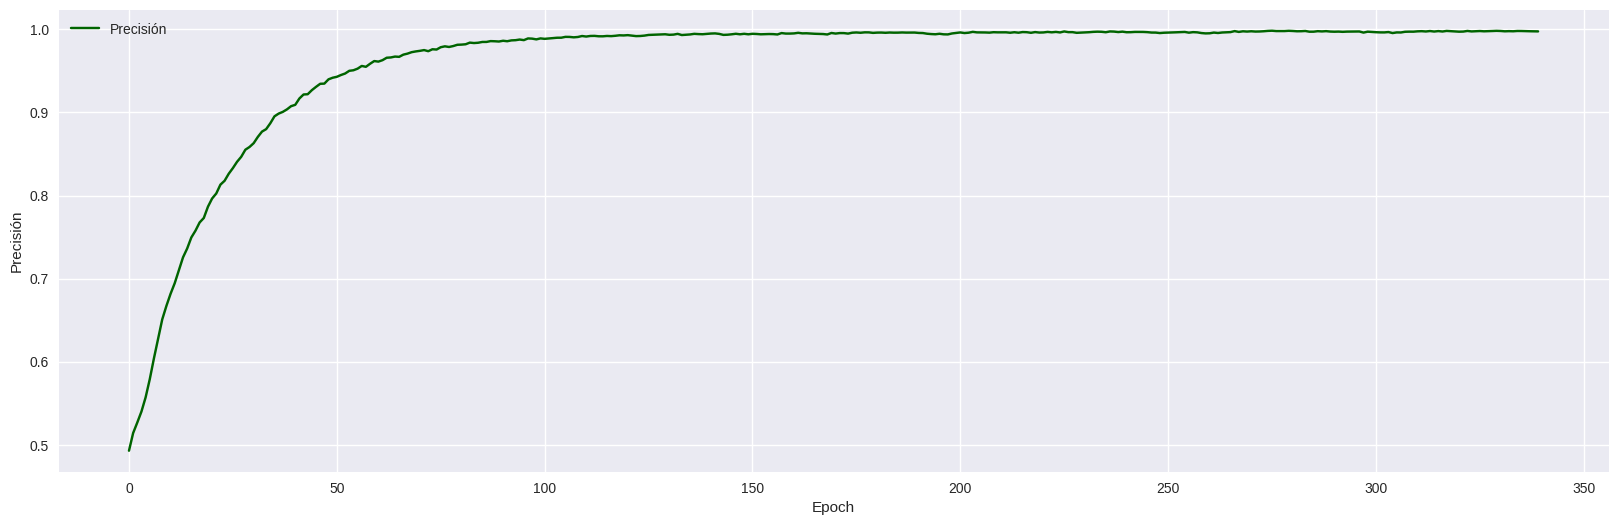

In [50]:
draw_plot(history_training.history['accuracy'],"darkgreen", "Precisión")

<ipython-input-49-235b6aa75655>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


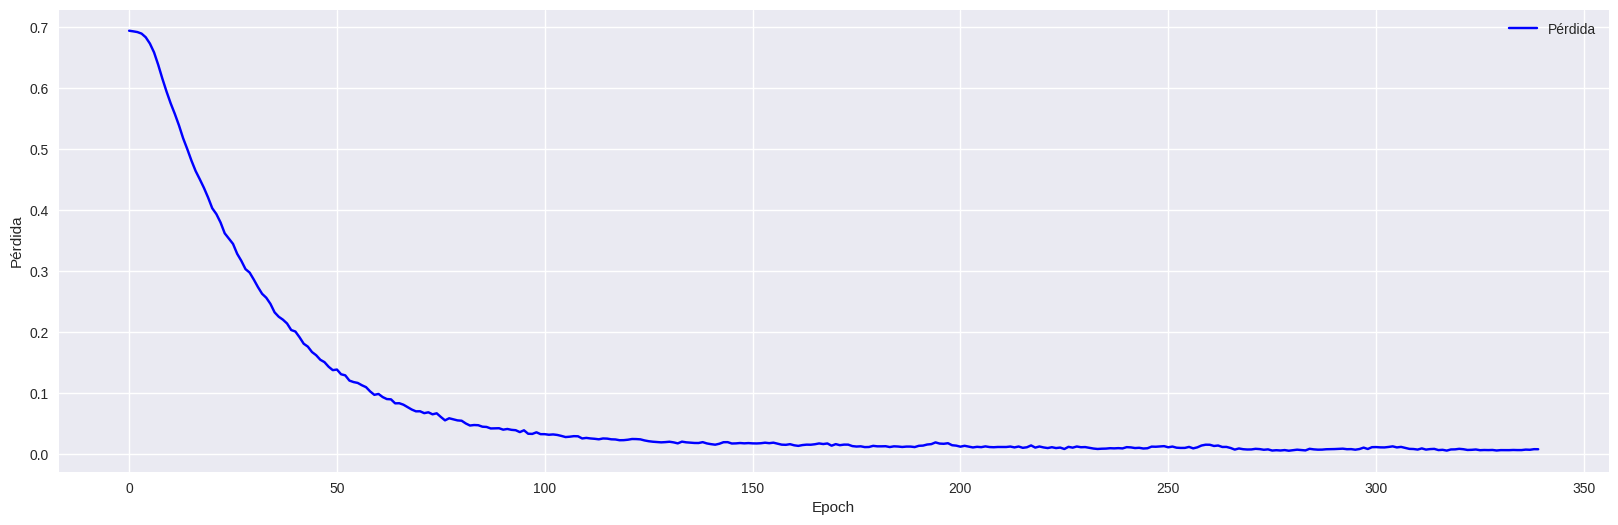

In [51]:

draw_plot(history_training.history['loss'],"blue", "Pérdida")

<ipython-input-49-235b6aa75655>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


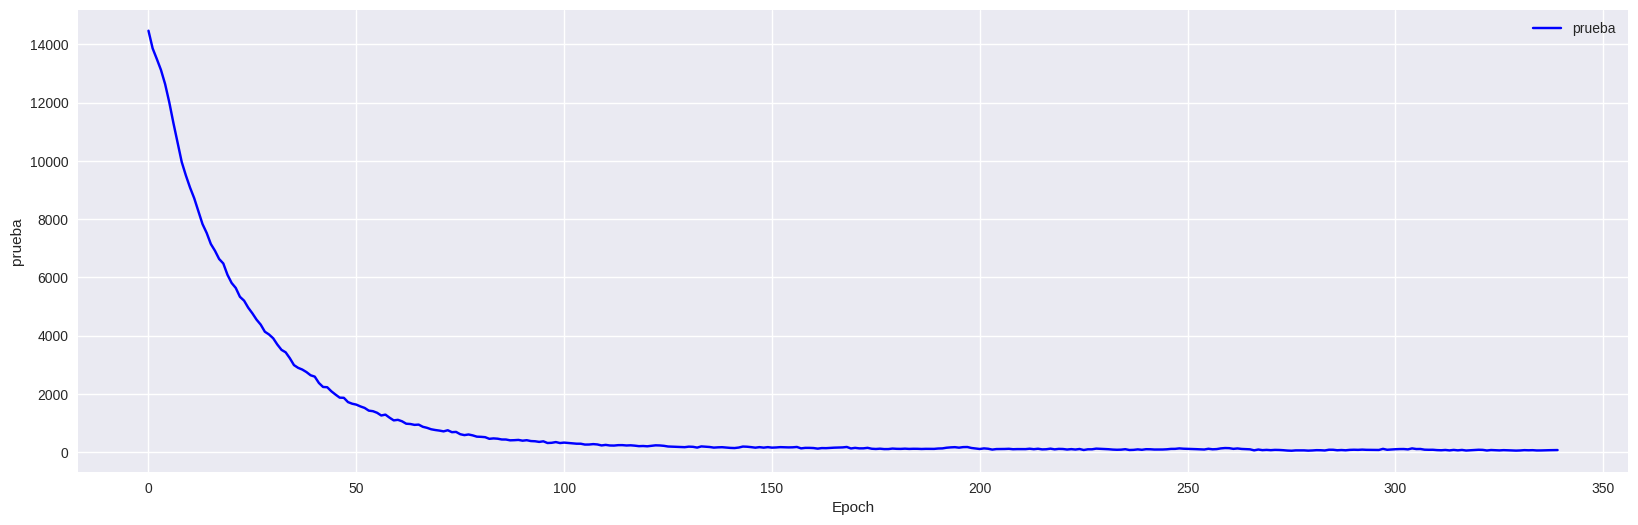

In [52]:
draw_plot(history_training.history['fn'],'blue','prueba')

In [53]:
#@title Cargar datos de prueba
df_prueba = pd.read_csv('/content/sample_data/snli_1.0_test.csv')
columnas_prueba = ['sentence1','sentence2','gold_label']
df_prueba = df_prueba[columnas_prueba]
df_prueba.dropna(axis=0, inplace=True) #Se eliminan datos nulos
df_prueba.head()

,sentence1,sentence2,gold_label
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment


In [54]:
df_prueba = df_prueba.loc[df_prueba['gold_label'] != "-"]   #Se botan las filas que contengan - y neutral
df_prueba = df_prueba.loc[df_prueba['gold_label'] != "neutral"]
df_prueba.shape

(6605, 3)

In [55]:
df_prueba = df_prueba.sample(frac = 1)
df_prueba["gold_label"] = (df_prueba["gold_label"] == "contradiction").astype(int)
df_prueba.head()

,sentence1,sentence2,gold_label
7287,A man from one football team trying to dodge a...,A man throws the first pitch in a baseball game.,1
1003,Three young boys enjoying a day at the beach.,The boys are sleeping.,1
8197,A soft focus picture of a little girl wearing ...,A girl is wearing orange.,0
9135,An individual is crouched down on top of rocks...,a person is outside,0
6045,People on a sidewalk are trying to protect the...,The people are sitting on benches in the sunsh...,1


In [56]:
df_prueba['sentence1'] = df_prueba['sentence1'].apply(limpiarTexto)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(limpiarTexto)
df_prueba.head()

,sentence1,sentence2,gold_label
7287,a man from one football team trying to dodge a...,a man throws the first pitch in a baseball game,1
1003,three young boys enjoying a day at the beach,the boys are sleeping,1
8197,a soft focus picture of a little girl wearing ...,a girl is wearing orange,0
9135,an individual is crouched down on top of rocks...,a person is outside,0
6045,people on a sidewalk are trying to protect the...,the people are sitting on benches in the sunshine,1


In [57]:
df_prueba['sentence1'] = df_prueba['sentence1'].apply(remove_stopwords)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(remove_stopwords)
df_prueba['sentence1'] = df_prueba['sentence1'].apply(stematizar)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(stematizar)

In [71]:
#@title Tokenización set de pruebas
sentencias_arreglo_prueba = np.asarray([df_prueba['sentence1'],df_prueba['sentence2']])
print(sentencias_arreglo_prueba)
sentencias_arreglo_prueba = sentencias_arreglo_prueba.reshape(-1,1)
sentencias_arreglo_prueba = sentencias_arreglo_prueba.reshape(sentencias_arreglo_prueba.shape[0])
tokenizar_prueba = Tokenizer(num_words=6000)
tokenizar_prueba.fit_on_texts(sentencias_arreglo_prueba)
texto_original_seq_prueba = tokenizar_prueba.texts_to_sequences(df_prueba['sentence1']) #Guarda un arreglo que en vez de palabras, posee índices de palabras
texto_original_prueba = pad_sequences(texto_original_seq_prueba,45) #Agrega padding para estandarizar el tamaño
hipotesis_seq_prueba = tokenizar_prueba.texts_to_sequences(df_prueba['sentence2'])
hipotesis_prueba = pad_sequences(hipotesis_seq_prueba, maxlen = texto_original_prueba.shape[1])
hipotesis_prueba.shape

[['man one footbal team tri dodg tackl player oppos footbal team'
  'three young boy enjoy day beach'
  'soft focus pictur littl girl wear orang sweater' ...
  'asian woman hat measur food barrel ladl smaller metal pan'
  'boy take shot team watch anxious'
  'larg black white dog lick smaller white black dog growl']
 ['man throw first pitch basebal game' 'boy sleep' 'girl wear orang' ...
  'woman measur wine barrel' 'boy bike' 'dog red']]


(6605, 45)

In [72]:
texto_original_prueba.shape

(6605, 45)

In [73]:
encoder_prueba = LabelEncoder()
etiquetas_prueba = df_prueba['gold_label']
etiquetas_prueba = encoder_prueba.fit_transform(etiquetas_prueba)
etiquetas_prueba = to_categorical(etiquetas_prueba)
etiquetas_prueba.shape

(6605, 2)

In [74]:
data_tokenizada_prueba = np.asarray([texto_original_prueba,hipotesis_prueba])
data_tokenizada_prueba = data_tokenizada_prueba.reshape(data_tokenizada_prueba.shape[1], 2, data_tokenizada_prueba.shape[2])
data_tokenizada_prueba.shape

(6605, 2, 45)

In [76]:
m.evaluate(data_tokenizada_prueba,etiquetas_prueba)

892/892 [==============================] - 7s 8ms/step - loss: 0.0017 - tp: 28526.0000 - fp: 8.0000 - tn: 28526.0000 - fn: 8.0000 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - AUC: 1.0000


[0.0017351089045405388,
 28526.0,
 8.0,
 28526.0,
 8.0,
 0.9997196197509766,
 0.9997196197509766,
 0.9997196197509766,
 0.9999996423721313]

In [69]:
prediccion = m.predict(data_tokenizada_prueba, batch_size = 1024, verbose = 1)
prediccion

7/7 [==============================] - 1s 29ms/step


array([[3.2800931e-01, 6.7199069e-01],
       [9.9999201e-01, 7.9625052e-06],
       [1.0000000e+00, 2.9688856e-18],
       ...,
       [5.7226163e-05, 9.9994278e-01],
       [9.8156295e-07, 9.9999905e-01],
       [1.3973382e-03, 9.9860269e-01]], dtype=float32)